In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [17]:
df = pd.read_csv('/Users/Adam/Downloads/dataset/heart_disease.csv')

In [19]:
df.head(5)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [21]:

# Quick look
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

#display(df.head())
#display(df.tail())

# Basic info
df.info()

# Summary statistics for numeric fields
df.describe()

Shape: (920, 15)

Columns: ['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(7)
memory usage: 107.9+ KB


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [26]:
# Original 'num' distribution (0..4)
print("Original 'num' distribution:")
print(df['num'].value_counts().sort_index())

Original 'num' distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [28]:
# Create binary target: 1 = any heart disease, 0 = none
df['target'] = (df['num'] > 0).astype(int)

print("\nBinary target distribution:")
print(df['target'].value_counts())
print("\nBinary target percentage:")
print((df['target'].value_counts(normalize=True) * 100).round(2))

# Missing values per column
print("\nMissing values per column:")
print(df.isna().sum())


Binary target distribution:
target
1    509
0    411
Name: count, dtype: int64

Binary target percentage:
target
1    55.33
0    44.67
Name: proportion, dtype: float64

Missing values per column:
id            0
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
target        0
dtype: int64


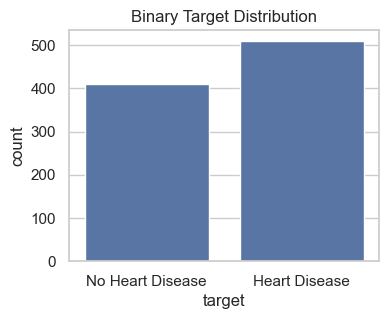

In [30]:
plt.figure(figsize=(4,3))
sns.countplot(x='target', data=df)
plt.xticks([0,1], ['No Heart Disease', 'Heart Disease'])
plt.title("Binary Target Distribution")
plt.show()

In [32]:
numeric_cols_all = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols_all = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

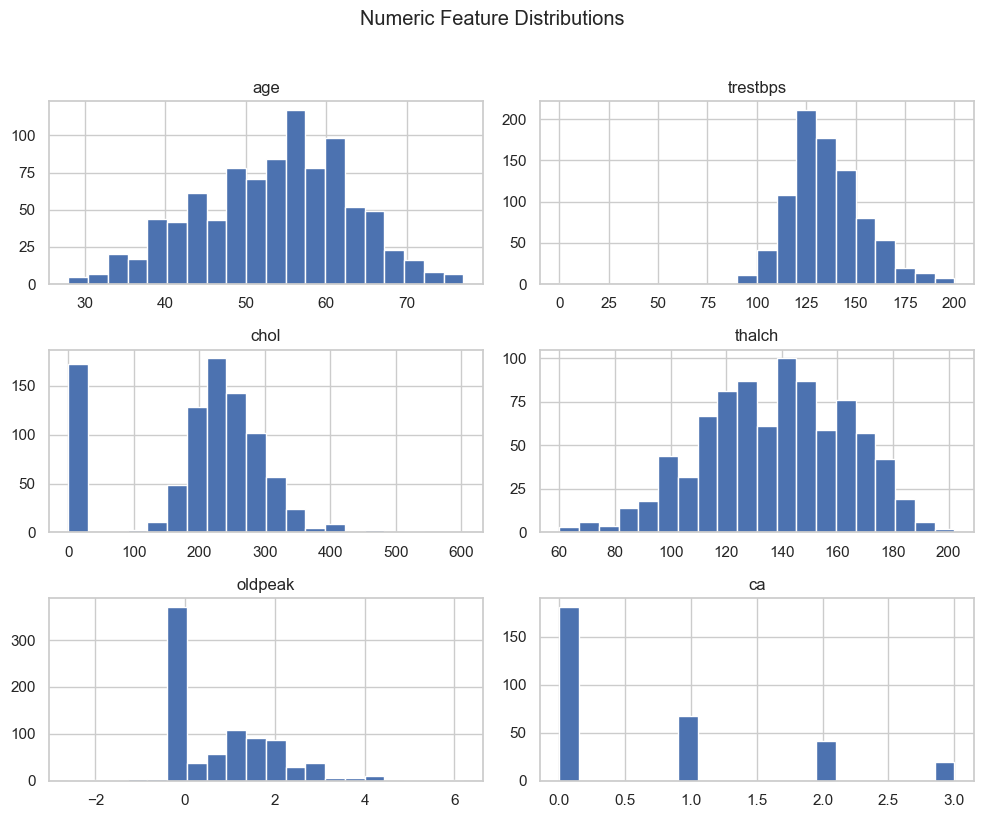

In [34]:
# Histograms for numeric variables
df[numeric_cols_all].hist(figsize=(10,8), bins=20)
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

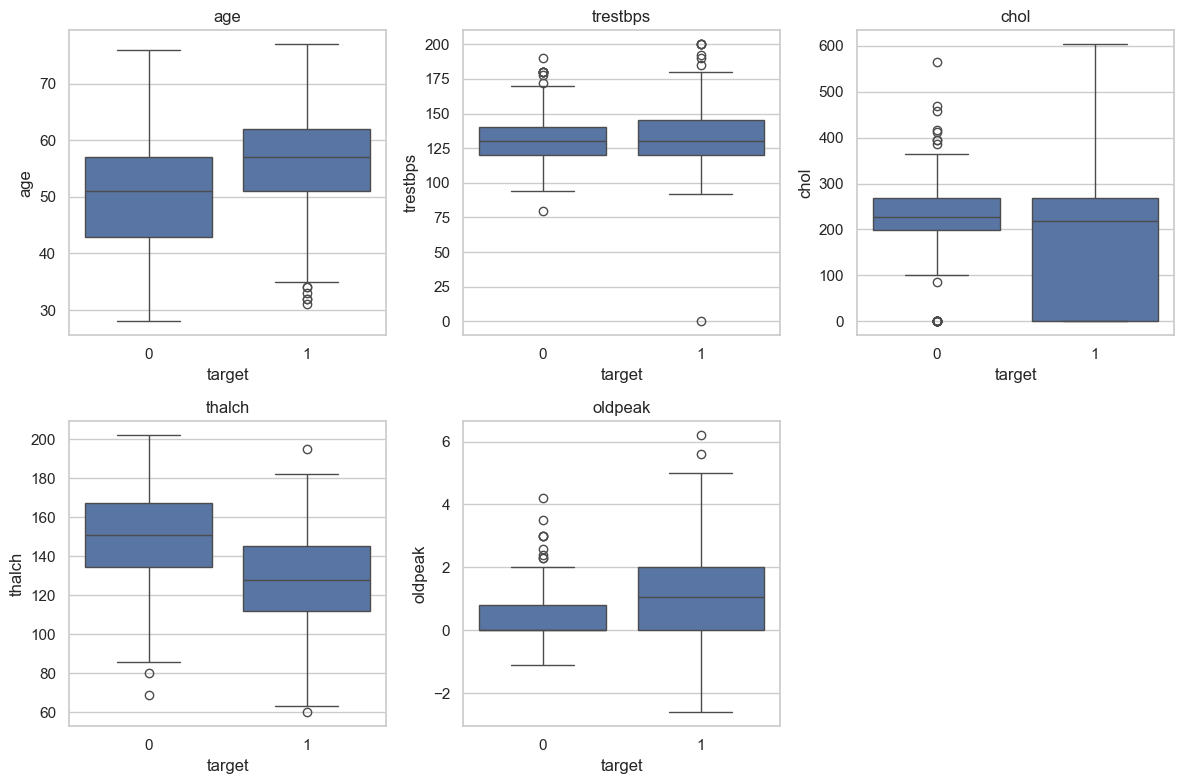

In [36]:
# Boxplots by target for some key variables
plt.figure(figsize=(12,8))
for i, col in enumerate(['age', 'trestbps', 'chol', 'thalch', 'oldpeak']):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='target', y=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()

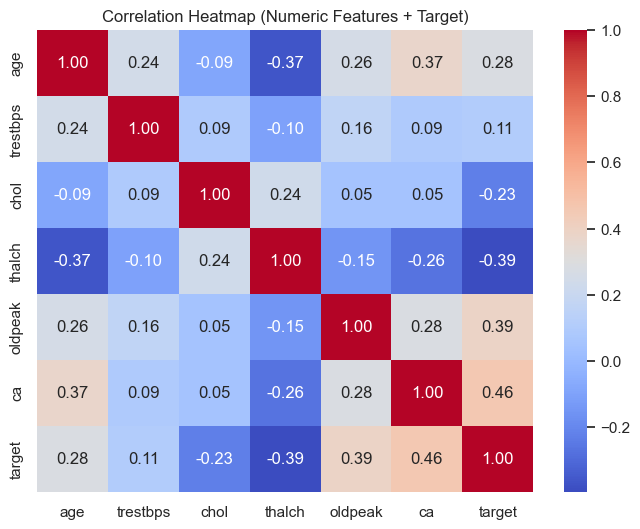

In [38]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(8,6))
corr = df[numeric_cols_all + ['target']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features + Target)")
plt.show()

In [42]:
# Features and target
X = df.drop(columns=['id', 'num', 'target'])  # drop id, original target, and dataset source
y = df['target']

In [44]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [46]:
# Impute missing values
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode().iloc[0])

print("\nMissing after imputation:")
print(X.isna().sum())


Missing after imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train target mean:", y_train.mean())
print("Test target mean:", y_test.mean())

Train size: 736
Test size: 184
Train target mean: 0.5529891304347826
Test target mean: 0.5543478260869565


In [50]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [52]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=4,
        loss_function="Logloss",
        verbose=False,
        random_state=42
    ),
    "Shallow Neural Network": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-4,
        max_iter=500,
        random_state=42
    )
}

In [54]:
results = []
fitted_models = {}

for name, clf in models.items():
    print(f"\n=== Training {name} ===")
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', clf)
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    roc  = roc_auc_score(y_test, y_proba)
    
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC-AUC:   {roc:.3f}")
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": roc
    })
    
    fitted_models[name] = pipe

results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
display(results_df)


=== Training Logistic Regression ===
Accuracy:  0.842
Precision: 0.841
Recall:    0.882
F1-score:  0.861
ROC-AUC:   0.904

=== Training SVM (RBF) ===
Accuracy:  0.842
Precision: 0.817
Recall:    0.922
F1-score:  0.866
ROC-AUC:   0.917

=== Training Random Forest ===
Accuracy:  0.864
Precision: 0.860
Recall:    0.902
F1-score:  0.880
ROC-AUC:   0.924

=== Training Gradient Boosting ===
Accuracy:  0.859
Precision: 0.852
Recall:    0.902
F1-score:  0.876
ROC-AUC:   0.912

=== Training HistGradientBoosting ===
Accuracy:  0.842
Precision: 0.835
Recall:    0.892
F1-score:  0.863
ROC-AUC:   0.899

=== Training XGBoost ===
Accuracy:  0.842
Precision: 0.841
Recall:    0.882
F1-score:  0.861
ROC-AUC:   0.907

=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 407, number of negative: 329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
2,Random Forest,0.864130,0.859813,0.901961,0.880383,0.923840
1,SVM (RBF),0.842391,0.817391,0.921569,0.866359,0.916667
3,Gradient Boosting,0.858696,0.851852,0.901961,0.876190,0.911884
7,CatBoost,0.847826,0.842593,0.892157,0.866667,0.908895
5,XGBoost,0.842391,0.841121,0.882353,0.861244,0.907341
0,Logistic Regression,0.842391,0.841121,0.882353,0.861244,0.903515
4,HistGradientBoosting,0.842391,0.834862,0.892157,0.862559,0.898972
6,LightGBM,0.853261,0.844037,0.901961,0.872038,0.894548
8,Shallow Neural Network,0.804348,0.794643,0.872549,0.831776,0.857484


In [58]:
# Pick best model by ROC-AUC
best_row = results_df.iloc[0]
best_model_name = best_row['Model']
print("Best model by ROC-AUC:", best_model_name)

best_model = fitted_models[best_model_name]

# Predictions
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

Best model by ROC-AUC: Random Forest


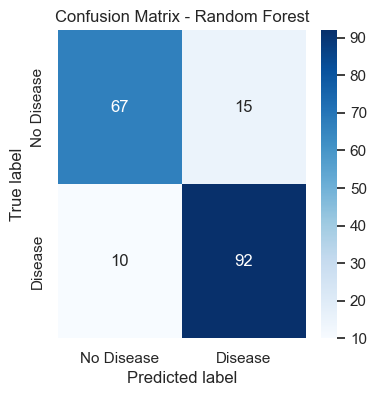

In [60]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

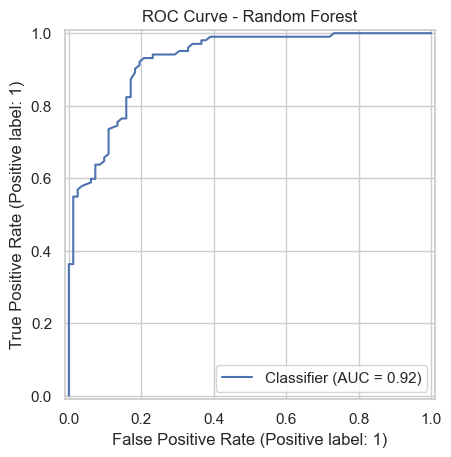

In [62]:
# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba_best)
plt.title(f'ROC Curve - {best_model_name}')
plt.show()

In [64]:
# Fit preprocessor alone to get transformed feature matrix
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, cat_feature_names])
print("Number of processed features:", len(all_feature_names))

Number of processed features: 25


In [68]:
# Extract underlying model (after pipeline)
best_clf = best_model.named_steps['model']

In [70]:
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test_processed)

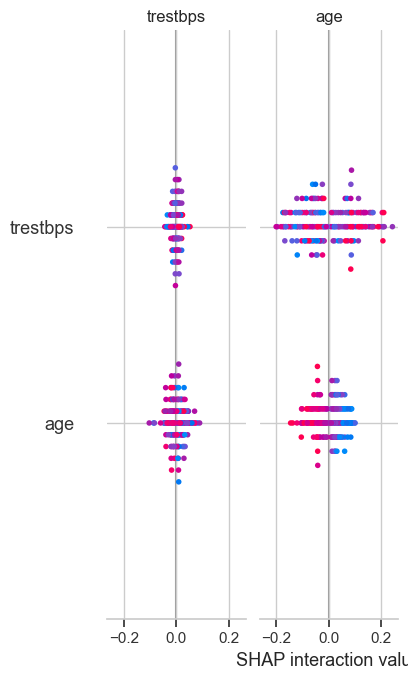

In [72]:
# Summary plot (global importance)
shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names)

In [74]:
# results_df sorted by ROC-AUC descending
best_model_name = results_df.iloc[0]["Model"]
best_model = fitted_models[best_model_name]

print("Best model:", best_model_name)

Best model: Random Forest


In [76]:
# Fit preprocessor separately on training data
preprocessor = best_model.named_steps["preprocessor"]
preprocessor.fit(X_train)

# Transform train/test
X_train_processed = preprocessor.transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
numeric_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=["int64","float64"]).columns.tolist()

ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)

all_feature_names = np.concatenate([numeric_cols, cat_feature_names])

print("Total processed features:", len(all_feature_names))

Total processed features: 25


                   Feature  Importance
2                     chol    0.131250
0                      age    0.111011
3                   thalch    0.107611
8          cp_asymptomatic    0.097486
4                  oldpeak    0.093592
1                 trestbps    0.072349
18              exang_True    0.063645
17             exang_False    0.043302
9       cp_atypical angina    0.042569
6               sex_Female    0.025885
23             thal_normal    0.025453
7                 sex_Male    0.023561
5                       ca    0.020313
15          restecg_normal    0.015712
24  thal_reversable defect    0.015453


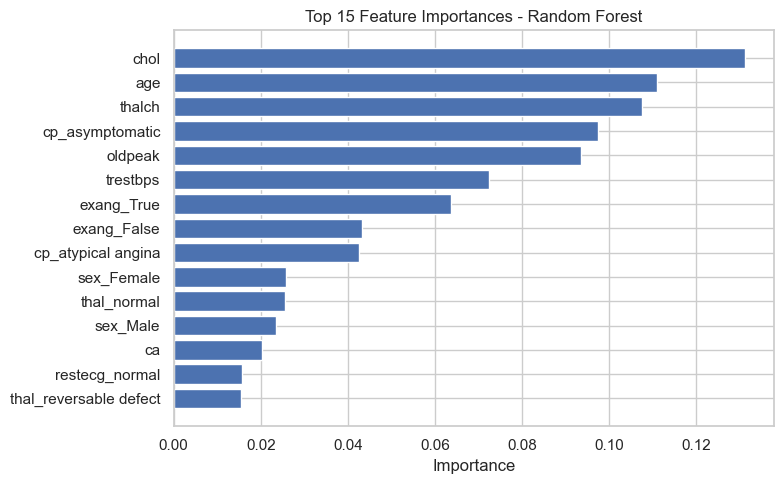

In [78]:
# Extract underlying classifier from pipeline
clf = best_model.named_steps["model"]

# Some models store importance differently
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    
    fi_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    print(fi_df.head(15))

    # Plot top 15
    plt.figure(figsize=(8,5))
    plt.barh(fi_df["Feature"].head(15)[::-1], fi_df["Importance"].head(15)[::-1])
    plt.title(f"Top 15 Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

else:
    print("This model does not provide feature_importances_.")

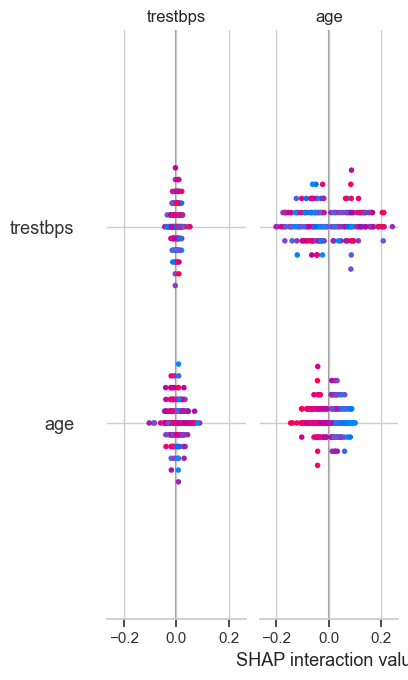

In [80]:
# TreeExplainer for tree-based models
explainer = shap.TreeExplainer(clf)

# Compute SHAP values on test set
shap_values = explainer.shap_values(X_test_processed)

# Summary plot (global importance)
shap.summary_plot(
    shap_values,
    X_test_processed,
    feature_names=all_feature_names
)

In [90]:
import numpy as np
import shap
from scipy import sparse

# 1) Get best model (you already have this)
best_model_name = results_df.iloc[0]["Model"]
best_model = fitted_models[best_model_name]
print("Best model:", best_model_name)

# 2) Pull out preprocessor and model
preprocessor = best_model.named_steps["preprocessor"]
clf = best_model.named_steps["model"]

# 3) Fit preprocessor on train, transform both sets
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# 4) Convert sparse matrices to dense (SHAP prefers dense)
if sparse.issparse(X_train_processed):
    X_train_processed = X_train_processed.toarray()
if sparse.issparse(X_test_processed):
    X_test_processed = X_test_processed.toarray()

# 5) Get correct feature names after one-hot
numeric_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=["int64","float64"]).columns.tolist()

ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)

all_feature_names = np.concatenate([numeric_cols, cat_feature_names])

print("X_test_processed shape:", X_test_processed.shape)
print("Expected feature count:", len(all_feature_names))

# 6) Compute SHAP values on the SAME processed matrix
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_processed)

# 7) If shap_values is a list (binary classification), take class 1
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print("shap_values shape:", np.array(shap_values).shape)

Best model: Random Forest
X_test_processed shape: (184, 25)
Expected feature count: 25
shap_values shape: (184, 25, 2)


In [130]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np